In [68]:
## Initial Setup

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

import pandas as pd
import numpy

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt


bs = 64

path = Path('./FAST_Utrasound_usingFASTAI_attempt2/')

np.random.seed(21) #locks the random seed



In [3]:

def floatlabeler(oof):
    func= lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[2]
    funcname= lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[3]
    frame = func(oof)
    framename = funcname(oof)
    print (frame)
    print (framename)
    
    if 'Quality1' in frame:
        label = 1.0
    if 'Quality2' in frame:
        label = 2.0
    if 'Quality3' in frame:
        label = 3.0
    if 'Quality4' in frame:
        label = 4.0
    if 'Quality5' in frame:
        label = 5.0
    return label
    

In [4]:
tfms = get_transforms(max_zoom=0, max_warp = None)
data = ImageList.from_folder(path).split_by_folder("train", "valid").label_from_func(floatlabeler, label_cls = FloatList).transform(tfms, size=224).databunch(no_check = True).normalize()

Quality1
video33347.mp4__frame110.png
Quality1
video33349.mp4__frame110.png
Quality1
video33351.mp4__frame110.png
Quality1
video33351.mp4__frame44.png
Quality1
video33351.mp4__frame66.png
Quality1
video33351.mp4__frame88.png
Quality1
video33352.mp4__frame110.png
Quality1
video33352.mp4__frame22.png
Quality1
video33352.mp4__frame44.png
Quality1
video33352.mp4__frame66.png
Quality1
video33353.mp4__frame66.png
Quality1
video33353.mp4__frame88.png
Quality1
video33408.mp4__frame132.png
Quality1
video33409.mp4__frame66.png
Quality1
video33410.mp4__frame110.png
Quality1
video33410.mp4__frame132.png
Quality1
video33410.mp4__frame154.png
Quality1
video33410.mp4__frame176.png
Quality1
video33410.mp4__frame44.png
Quality1
video33410.mp4__frame66.png
Quality1
video33411.mp4__frame176.png
Quality1
video33412.mp4__frame110.png
Quality1
video33412.mp4__frame176.png
Quality1
video33412.mp4__frame22.png
Quality1
video33412.mp4__frame44.png
Quality1
video33616.mp4__frame110.png
Quality1
video33616.mp4__

In [5]:
#data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(max_zoom=0, max_warp = None), size=224, bs=bs).normalize(imagenet_stats).split_by_folder('train', 'valid').label_from_func(floatlabeler, label_cls = FloatList)

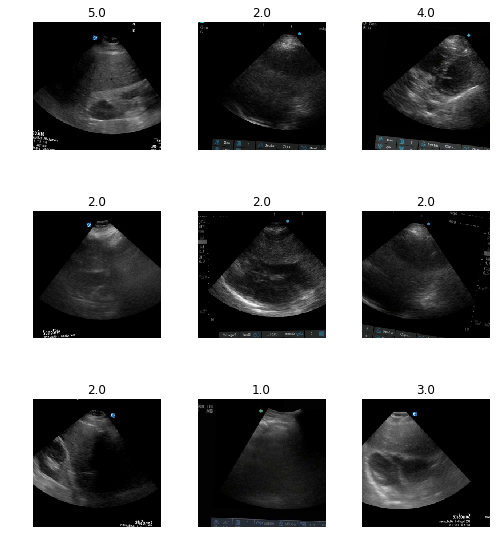

In [6]:
data.show_batch(rows=3, figsize = (7,8))

In [7]:
learn = cnn_learner(data, models.resnet34, metrics = mean_absolute_error, wd = 15)

In [8]:
#torch.nn.modules.Sigmoid??

In [9]:
def sigmoid_1to5(input, buffer=0):
    return (4+2*buffer) + torch.sigmoid(input) + (1-buffer)

class Sigmoid_1to5(torch.nn.Module):    
    def sigmoid_1to5(self, input, buffer=0):
        return (4+2*buffer) * torch.sigmoid(input) + (1-buffer)
    
    def forward(self, input):
        return self.sigmoid_1to5(input, buffer=0.5)

In [11]:
sig = Sigmoid_1to5()


In [12]:
x=torch.tensor(np.linspace(-10, 10, 50).astype(float))
y=sig(x)

In [14]:
learn.model[1].add_module(module = Sigmoid_1to5(), name = '9')

In [15]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

epoch,train_loss,valid_loss,mean_absolute_error,time
0,2.533455,1.636135,1.075482,00:07
1,2.136431,1.215259,0.908432,00:06
2,1.756431,1.126033,0.863982,00:06
3,1.476050,1.175918,0.890442,00:07
4,1.260668,1.200565,0.916498,00:06
5,1.124713,1.245861,0.936352,00:06
6,1.027366,1.222739,0.916919,00:06
7,0.962925,1.195024,0.910007,00:06
8,0.909174,1.222904,0.891902,00:06
9,0.869075,1.203613,0.881736,00:06


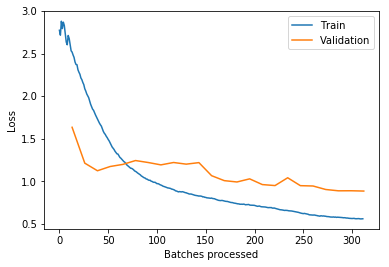

In [16]:
learn.fit_one_cycle(24)
learn.recorder.plot_losses()

In [17]:
learn.save('Test-1')


In [56]:
learn.unfreeze()

In [57]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


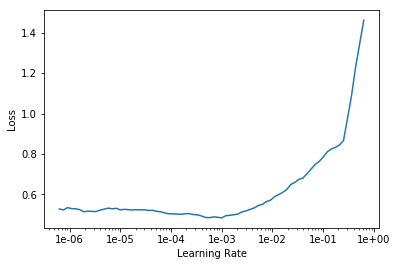

In [58]:
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.539688,0.822220,0.749931,00:07
1,0.522501,0.814489,0.745267,00:07
2,0.496901,0.784645,0.736355,00:07
3,0.480361,0.745677,0.718941,00:07
4,0.448884,0.746374,0.706161,00:07
5,0.411802,0.786912,0.722899,00:07
6,0.380463,0.791619,0.728057,00:07
7,0.359439,0.791886,0.719544,00:07
8,0.331235,0.758688,0.703566,00:07
9,0.313413,0.765996,0.711123,00:07


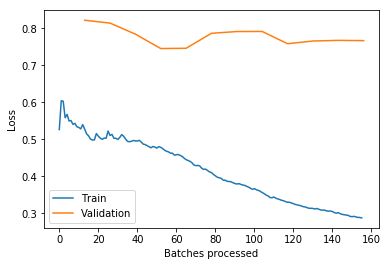

In [60]:
learn.fit_one_cycle(12, max_lr=slice(1e-05,1e-04))
learn.recorder.plot_losses()

In [74]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

In [71]:
Valid_DF = pd.DataFrame([], columns = ['Predicted', 'Actual']).reset_index()
Valid_DF.head()

In [80]:
i = 0
batchnum = 0
while batchnum < 3:
    xb, yb = data.one_batch(ds_type = DatasetType.Valid)
    xb=xb.cuda()
    ypred = learn.model(xb).cpu().detach().numpy()
    for x, y in zip(ypred, yb.numpy()):
        dfnew = pd.DataFrame({'Predicted': float(x), 'Actual': float(y)}, index = [i])
        Valid_DF = Valid_DF.append(dfnew, ignore_index=False)
        i = i + 1
    batchnum=+1

   Predicted  Actual
0   1.783589     1.0
   Predicted  Actual
1   1.985897     1.0
   Predicted  Actual
2   1.826449     1.0
   Predicted  Actual
3   2.103336     1.0
   Predicted  Actual
4   1.924181     1.0
   Predicted  Actual
5   1.733429     1.0
   Predicted  Actual
6   1.892772     1.0
   Predicted  Actual
7   1.875924     1.0
   Predicted  Actual
8    1.83606     1.0
   Predicted  Actual
9   1.756117     1.0
    Predicted  Actual
10   1.711977     1.0
    Predicted  Actual
11   1.837615     1.0
    Predicted  Actual
12   1.767862     1.0
    Predicted  Actual
13   1.917086     1.0
    Predicted  Actual
14   1.750134     1.0
    Predicted  Actual
15    1.86378     1.0
    Predicted  Actual
16   1.745055     1.0
    Predicted  Actual
17   1.777213     1.0
    Predicted  Actual
18   1.720462     1.0
    Predicted  Actual
19   1.758408     1.0
    Predicted  Actual
20   1.744233     1.0
    Predicted  Actual
21   1.650981     1.0
    Predicted  Actual
22   1.601698     1.0
    Pred

     Predicted  Actual
192   1.783589     1.0
     Predicted  Actual
193   1.985897     1.0
     Predicted  Actual
194   1.826449     1.0
     Predicted  Actual
195   2.103336     1.0
     Predicted  Actual
196   1.924181     1.0
     Predicted  Actual
197   1.733429     1.0
     Predicted  Actual
198   1.892772     1.0
     Predicted  Actual
199   1.875924     1.0
     Predicted  Actual
200    1.83606     1.0
     Predicted  Actual
201   1.756117     1.0
     Predicted  Actual
202   1.711977     1.0
     Predicted  Actual
203   1.837615     1.0
     Predicted  Actual
204   1.767862     1.0
     Predicted  Actual
205   1.917086     1.0
     Predicted  Actual
206   1.750134     1.0
     Predicted  Actual
207    1.86378     1.0
     Predicted  Actual
208   1.745055     1.0
     Predicted  Actual
209   1.777213     1.0
     Predicted  Actual
210   1.720462     1.0
     Predicted  Actual
211   1.758408     1.0
     Predicted  Actual
212   1.744233     1.0
     Predicted  Actual
213   1.650

     Predicted  Actual
383   1.823879     2.0
     Predicted  Actual
384   1.783589     1.0
     Predicted  Actual
385   1.985897     1.0
     Predicted  Actual
386   1.826449     1.0
     Predicted  Actual
387   2.103336     1.0
     Predicted  Actual
388   1.924181     1.0
     Predicted  Actual
389   1.733429     1.0
     Predicted  Actual
390   1.892772     1.0
     Predicted  Actual
391   1.875924     1.0
     Predicted  Actual
392    1.83606     1.0
     Predicted  Actual
393   1.756117     1.0
     Predicted  Actual
394   1.711977     1.0
     Predicted  Actual
395   1.837615     1.0
     Predicted  Actual
396   1.767862     1.0
     Predicted  Actual
397   1.917086     1.0
     Predicted  Actual
398   1.750134     1.0
     Predicted  Actual
399    1.86378     1.0
     Predicted  Actual
400   1.745055     1.0
     Predicted  Actual
401   1.777213     1.0
     Predicted  Actual
402   1.720462     1.0
     Predicted  Actual
403   1.758408     1.0
     Predicted  Actual
404   1.744

     Predicted  Actual
574   1.959276     2.0
     Predicted  Actual
575   1.823879     2.0
     Predicted  Actual
576   1.783589     1.0
     Predicted  Actual
577   1.985897     1.0
     Predicted  Actual
578   1.826449     1.0
     Predicted  Actual
579   2.103336     1.0
     Predicted  Actual
580   1.924181     1.0
     Predicted  Actual
581   1.733429     1.0
     Predicted  Actual
582   1.892772     1.0
     Predicted  Actual
583   1.875924     1.0
     Predicted  Actual
584    1.83606     1.0
     Predicted  Actual
585   1.756117     1.0
     Predicted  Actual
586   1.711977     1.0
     Predicted  Actual
587   1.837615     1.0
     Predicted  Actual
588   1.767862     1.0
     Predicted  Actual
589   1.917086     1.0
     Predicted  Actual
590   1.750134     1.0
     Predicted  Actual
591    1.86378     1.0
     Predicted  Actual
592   1.745055     1.0
     Predicted  Actual
593   1.777213     1.0
     Predicted  Actual
594   1.720462     1.0
     Predicted  Actual
595   1.758

     Predicted  Actual
767   1.823879     2.0
     Predicted  Actual
768   1.783589     1.0
     Predicted  Actual
769   1.985897     1.0
     Predicted  Actual
770   1.826449     1.0
     Predicted  Actual
771   2.103336     1.0
     Predicted  Actual
772   1.924181     1.0
     Predicted  Actual
773   1.733429     1.0
     Predicted  Actual
774   1.892772     1.0
     Predicted  Actual
775   1.875924     1.0
     Predicted  Actual
776    1.83606     1.0
     Predicted  Actual
777   1.756117     1.0
     Predicted  Actual
778   1.711977     1.0
     Predicted  Actual
779   1.837615     1.0
     Predicted  Actual
780   1.767862     1.0
     Predicted  Actual
781   1.917086     1.0
     Predicted  Actual
782   1.750134     1.0
     Predicted  Actual
783    1.86378     1.0
     Predicted  Actual
784   1.745055     1.0
     Predicted  Actual
785   1.777213     1.0
     Predicted  Actual
786   1.720462     1.0
     Predicted  Actual
787   1.758408     1.0
     Predicted  Actual
788   1.744

     Predicted  Actual
958   1.959276     2.0
     Predicted  Actual
959   1.823879     2.0
     Predicted  Actual
960   1.783589     1.0
     Predicted  Actual
961   1.985897     1.0
     Predicted  Actual
962   1.826449     1.0
     Predicted  Actual
963   2.103336     1.0
     Predicted  Actual
964   1.924181     1.0
     Predicted  Actual
965   1.733429     1.0
     Predicted  Actual
966   1.892772     1.0
     Predicted  Actual
967   1.875924     1.0
     Predicted  Actual
968    1.83606     1.0
     Predicted  Actual
969   1.756117     1.0
     Predicted  Actual
970   1.711977     1.0
     Predicted  Actual
971   1.837615     1.0
     Predicted  Actual
972   1.767862     1.0
     Predicted  Actual
973   1.917086     1.0
     Predicted  Actual
974   1.750134     1.0
     Predicted  Actual
975    1.86378     1.0
     Predicted  Actual
976   1.745055     1.0
     Predicted  Actual
977   1.777213     1.0
     Predicted  Actual
978   1.720462     1.0
     Predicted  Actual
979   1.758

      Predicted  Actual
1150   1.959276     2.0
      Predicted  Actual
1151   1.823879     2.0
      Predicted  Actual
1152   1.783589     1.0
      Predicted  Actual
1153   1.985897     1.0
      Predicted  Actual
1154   1.826449     1.0
      Predicted  Actual
1155   2.103336     1.0
      Predicted  Actual
1156   1.924181     1.0
      Predicted  Actual
1157   1.733429     1.0
      Predicted  Actual
1158   1.892772     1.0
      Predicted  Actual
1159   1.875924     1.0
      Predicted  Actual
1160    1.83606     1.0
      Predicted  Actual
1161   1.756117     1.0
      Predicted  Actual
1162   1.711977     1.0
      Predicted  Actual
1163   1.837615     1.0
      Predicted  Actual
1164   1.767862     1.0
      Predicted  Actual
1165   1.917086     1.0
      Predicted  Actual
1166   1.750134     1.0
      Predicted  Actual
1167    1.86378     1.0
      Predicted  Actual
1168   1.745055     1.0
      Predicted  Actual
1169   1.777213     1.0
      Predicted  Actual
1170   1.720462 

      Predicted  Actual
1342   1.959276     2.0
      Predicted  Actual
1343   1.823879     2.0
      Predicted  Actual
1344   1.783589     1.0
      Predicted  Actual
1345   1.985897     1.0
      Predicted  Actual
1346   1.826449     1.0
      Predicted  Actual
1347   2.103336     1.0
      Predicted  Actual
1348   1.924181     1.0
      Predicted  Actual
1349   1.733429     1.0
      Predicted  Actual
1350   1.892772     1.0
      Predicted  Actual
1351   1.875924     1.0
      Predicted  Actual
1352    1.83606     1.0
      Predicted  Actual
1353   1.756117     1.0
      Predicted  Actual
1354   1.711977     1.0
      Predicted  Actual
1355   1.837615     1.0
      Predicted  Actual
1356   1.767862     1.0
      Predicted  Actual
1357   1.917086     1.0
      Predicted  Actual
1358   1.750134     1.0
      Predicted  Actual
1359    1.86378     1.0
      Predicted  Actual
1360   1.745055     1.0
      Predicted  Actual
1361   1.777213     1.0
      Predicted  Actual
1362   1.720462 

      Predicted  Actual
1534   1.959276     2.0
      Predicted  Actual
1535   1.823879     2.0
      Predicted  Actual
1536   1.783589     1.0
      Predicted  Actual
1537   1.985897     1.0
      Predicted  Actual
1538   1.826449     1.0
      Predicted  Actual
1539   2.103336     1.0
      Predicted  Actual
1540   1.924181     1.0
      Predicted  Actual
1541   1.733429     1.0
      Predicted  Actual
1542   1.892772     1.0
      Predicted  Actual
1543   1.875924     1.0
      Predicted  Actual
1544    1.83606     1.0
      Predicted  Actual
1545   1.756117     1.0
      Predicted  Actual
1546   1.711977     1.0
      Predicted  Actual
1547   1.837615     1.0
      Predicted  Actual
1548   1.767862     1.0
      Predicted  Actual
1549   1.917086     1.0
      Predicted  Actual
1550   1.750134     1.0
      Predicted  Actual
1551    1.86378     1.0
      Predicted  Actual
1552   1.745055     1.0
      Predicted  Actual
1553   1.777213     1.0
      Predicted  Actual
1554   1.720462 

      Predicted  Actual
1727   1.823879     2.0
      Predicted  Actual
1728   1.783589     1.0
      Predicted  Actual
1729   1.985897     1.0
      Predicted  Actual
1730   1.826449     1.0
      Predicted  Actual
1731   2.103336     1.0
      Predicted  Actual
1732   1.924181     1.0
      Predicted  Actual
1733   1.733429     1.0
      Predicted  Actual
1734   1.892772     1.0
      Predicted  Actual
1735   1.875924     1.0
      Predicted  Actual
1736    1.83606     1.0
      Predicted  Actual
1737   1.756117     1.0
      Predicted  Actual
1738   1.711977     1.0
      Predicted  Actual
1739   1.837615     1.0
      Predicted  Actual
1740   1.767862     1.0
      Predicted  Actual
1741   1.917086     1.0
      Predicted  Actual
1742   1.750134     1.0
      Predicted  Actual
1743    1.86378     1.0
      Predicted  Actual
1744   1.745055     1.0
      Predicted  Actual
1745   1.777213     1.0
      Predicted  Actual
1746   1.720462     1.0
      Predicted  Actual
1747   1.758408 

      Predicted  Actual
1917   1.791371     2.0
      Predicted  Actual
1918   1.959276     2.0
      Predicted  Actual
1919   1.823879     2.0
      Predicted  Actual
1920   1.783589     1.0
      Predicted  Actual
1921   1.985897     1.0
      Predicted  Actual
1922   1.826449     1.0
      Predicted  Actual
1923   2.103336     1.0
      Predicted  Actual
1924   1.924181     1.0
      Predicted  Actual
1925   1.733429     1.0
      Predicted  Actual
1926   1.892772     1.0
      Predicted  Actual
1927   1.875924     1.0
      Predicted  Actual
1928    1.83606     1.0
      Predicted  Actual
1929   1.756117     1.0
      Predicted  Actual
1930   1.711977     1.0
      Predicted  Actual
1931   1.837615     1.0
      Predicted  Actual
1932   1.767862     1.0
      Predicted  Actual
1933   1.917086     1.0
      Predicted  Actual
1934   1.750134     1.0
      Predicted  Actual
1935    1.86378     1.0
      Predicted  Actual
1936   1.745055     1.0
      Predicted  Actual
1937   1.777213 

      Predicted  Actual
2109   1.791371     2.0
      Predicted  Actual
2110   1.959276     2.0
      Predicted  Actual
2111   1.823879     2.0
      Predicted  Actual
2112   1.783589     1.0
      Predicted  Actual
2113   1.985897     1.0
      Predicted  Actual
2114   1.826449     1.0
      Predicted  Actual
2115   2.103336     1.0
      Predicted  Actual
2116   1.924181     1.0
      Predicted  Actual
2117   1.733429     1.0
      Predicted  Actual
2118   1.892772     1.0
      Predicted  Actual
2119   1.875924     1.0
      Predicted  Actual
2120    1.83606     1.0
      Predicted  Actual
2121   1.756117     1.0
      Predicted  Actual
2122   1.711977     1.0
      Predicted  Actual
2123   1.837615     1.0
      Predicted  Actual
2124   1.767862     1.0
      Predicted  Actual
2125   1.917086     1.0
      Predicted  Actual
2126   1.750134     1.0
      Predicted  Actual
2127    1.86378     1.0
      Predicted  Actual
2128   1.745055     1.0
      Predicted  Actual
2129   1.777213 

      Predicted  Actual
2298   2.017036     2.0
      Predicted  Actual
2299   1.719846     2.0
      Predicted  Actual
2300   1.885135     2.0
      Predicted  Actual
2301   1.791371     2.0
      Predicted  Actual
2302   1.959276     2.0
      Predicted  Actual
2303   1.823879     2.0
      Predicted  Actual
2304   1.783589     1.0
      Predicted  Actual
2305   1.985897     1.0
      Predicted  Actual
2306   1.826449     1.0
      Predicted  Actual
2307   2.103336     1.0
      Predicted  Actual
2308   1.924181     1.0
      Predicted  Actual
2309   1.733429     1.0
      Predicted  Actual
2310   1.892772     1.0
      Predicted  Actual
2311   1.875924     1.0
      Predicted  Actual
2312    1.83606     1.0
      Predicted  Actual
2313   1.756117     1.0
      Predicted  Actual
2314   1.711977     1.0
      Predicted  Actual
2315   1.837615     1.0
      Predicted  Actual
2316   1.767862     1.0
      Predicted  Actual
2317   1.917086     1.0
      Predicted  Actual
2318   1.750134 

      Predicted  Actual
2493   1.791371     2.0
      Predicted  Actual
2494   1.959276     2.0
      Predicted  Actual
2495   1.823879     2.0
      Predicted  Actual
2496   1.783589     1.0
      Predicted  Actual
2497   1.985897     1.0
      Predicted  Actual
2498   1.826449     1.0
      Predicted  Actual
2499   2.103336     1.0
      Predicted  Actual
2500   1.924181     1.0
      Predicted  Actual
2501   1.733429     1.0
      Predicted  Actual
2502   1.892772     1.0
      Predicted  Actual
2503   1.875924     1.0
      Predicted  Actual
2504    1.83606     1.0
      Predicted  Actual
2505   1.756117     1.0
      Predicted  Actual
2506   1.711977     1.0
      Predicted  Actual
2507   1.837615     1.0
      Predicted  Actual
2508   1.767862     1.0
      Predicted  Actual
2509   1.917086     1.0
      Predicted  Actual
2510   1.750134     1.0
      Predicted  Actual
2511    1.86378     1.0
      Predicted  Actual
2512   1.745055     1.0
      Predicted  Actual
2513   1.777213 

KeyboardInterrupt: 

In [81]:
Valid_DF.head()

,Actual,Predicted,index
0,1.0,1.783589,NaN
1,1.0,1.985897,NaN
2,1.0,1.826449,NaN
3,1.0,2.103336,NaN
4,1.0,1.924181,NaN


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Confusion matrix, without normalization
[[ 0 70]
 [ 0 58]]


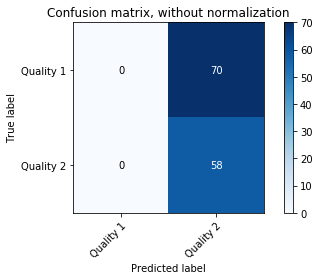

In [73]:
# confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
  

CalQual = Valid_DF["Predicted"].values.tolist()
i = 0
for x in CalQual:
  if x<1:
    CalQual[i] = 1
  elif x> 5:
    CalQual[i] = 5
  else:
    CalQual[i] = round(x)
  i = i + 1
  
print(CalQual) 
  
TruQual = Valid_DF['Actual'].values.tolist()

a = plot_confusion_matrix(TruQual, CalQual, classes = ['Quality 1', 'Quality 2', 'Quality 3', 'Quality 4', 'Quality 5']) 
  
#plt.savefig("confusion_matrix_WOnorm.png")

## RESNET 50

In [90]:
learn2 = cnn_learner(data, models.resnet50, metrics = mean_absolute_error)

In [91]:
learn2.fit_one_cycle(12)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,9.286983,11.918430,3.263761,00:12
1,8.489308,10.116733,2.975995,00:08
2,7.279351,3.086784,1.456157,00:08
3,5.529927,1.864127,1.082813,00:08
4,4.221506,1.166993,0.880349,00:08
5,3.358155,1.155834,0.896107,00:08
6,2.727327,1.192101,0.883848,00:08
7,2.240418,1.086237,0.850643,00:08
8,1.880705,0.991900,0.821274,00:08
9,1.615084,0.996682,0.816715,00:08


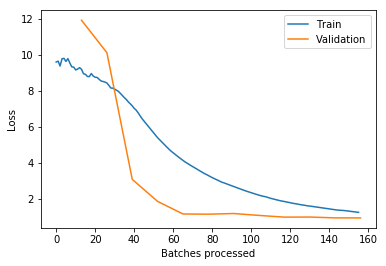

In [93]:
learn2.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


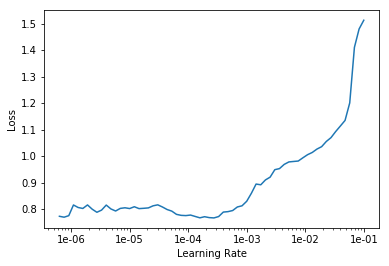

In [94]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.773828,0.945766,0.796726,00:08
1,0.810001,0.950327,0.797653,00:08
2,0.776439,0.948971,0.795623,00:08
3,0.766475,0.969003,0.805179,00:08
4,0.762246,0.942455,0.791648,00:08
5,0.738901,0.938736,0.790143,00:08
6,0.731104,0.945171,0.795291,00:08
7,0.737219,0.941966,0.793518,00:08
8,0.728049,0.931591,0.788105,00:08
9,0.717539,0.932894,0.790413,00:08


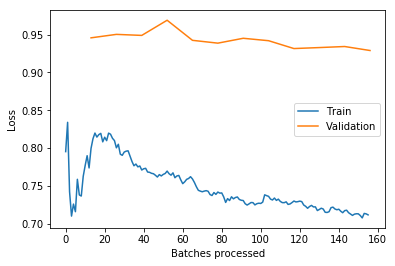

In [95]:
learn2.fit_one_cycle(12, max_lr=slice(3e-05,1.5e-04))
learn2.recorder.plot_losses()

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.701769,0.930196,0.786817,00:08
1,0.719644,0.925859,0.784110,00:08
2,0.717179,0.915754,0.777580,00:08
3,0.724021,0.926400,0.784525,00:08
4,0.703544,0.924809,0.780664,00:08
5,0.680908,0.916139,0.775311,00:08
6,0.699634,0.917839,0.772465,00:08
7,0.691749,0.913381,0.770167,00:08
8,0.685273,0.901461,0.763477,00:08
9,0.687274,0.920109,0.770701,00:08


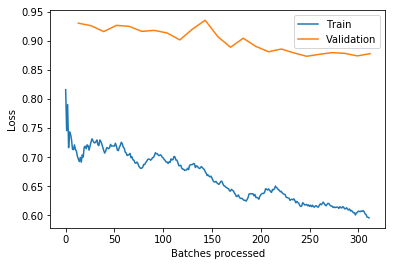

In [96]:
learn2.fit_one_cycle(24, max_lr=slice(3e-05,1.5e-04))
learn2.recorder.plot_losses()

TypeError: 'NBMasterBar' object is not callable

True

AttributeError: classes